# Load dependencies

***The utilities and pipelines can be found in the support module***

In [82]:
# Data manipulation
import pandas as pd
import numpy as np

# Model evaluation
from sklearn.metrics import make_scorer, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, power_transform
from sklearn.model_selection import train_test_split, cross_val_predict
from yellowbrick.model_selection import LearningCurve

# Support
from support.pipeline import *
from support.utility import *
from sklearn.pipeline import Pipeline

# Classifiers
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Vizaualisation
from matplotlib import pyplot as plt
import scikitplot as skplt
import seaborn as sns


from sklearn import set_config # to change the display
# set config to diagram for visualizing the pipelines/composite estimators
set_config(display='diagram')


%matplotlib inline

Let's setup an unitary cost of 19€ to target a customer with our loyalty process. And an average revenue of 150€

In [2]:
avg_revenue=150
avg_cost=-19

In [3]:
features, target = load_data('data/train.csv',"Attrited Customer", "Existing Customer")
features = features.drop(["CLIENTNUM"], axis=1)
features.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,48,F,4,Uneducated,Married,Less than $40K,Blue,41,5,3,4,2340.0,1680,660.0,0.791,4751,83,0.804,0.718
1,41,F,3,High School,Married,Less than $40K,Blue,31,3,3,3,3952.0,0,3952.0,1.002,8241,82,0.952,0.000
2,50,F,2,Uneducated,Single,Less than $40K,Blue,36,5,3,2,1721.0,1037,684.0,0.721,2681,57,0.727,0.603
3,44,F,4,Graduate,Married,Unknown,Blue,34,6,4,2,2105.0,0,2105.0,0.656,4190,67,0.914,0.000
4,57,M,2,Uneducated,Unknown,$80K - $120K,Blue,48,4,1,3,30543.0,264,30279.0,0.882,7784,63,0.703,0.009


In [4]:
features['Total_Amt_Chng_Q4_Q1'] = power_transform(np.array(features['Total_Amt_Chng_Q4_Q1']+1).reshape(-1, 1), method='box-cox')
features['Total_Trans_Amt'] = (features['Total_Trans_Amt']+1).transform(np.log)

In [5]:
nb_obs = features.shape[0]
p_instances = target.sum() / nb_obs
p_targeted = .13
n_targeted = int(nb_obs*p_targeted)

print('Number of instances: {:,}'.format(nb_obs))
print('Number of conversions {:,}'.format(target.sum()))
print('Conversion rate: {:.2f}%'.format(p_instances*100.))
print('13% of the population {:,}'.format(n_targeted))

Number of instances: 7,088
Number of conversions 1,139
Conversion rate: 16.07%
13% of the population 921


In [6]:
scorer = get_scorer()
pipeline = build_pipeline()
ps = pipeline.fit_transform(features)
print('Instances: {:,}, Features: {}'.format(ps.shape[0], ps.shape[1]))

Instances: 7,088, Features: 34


In [7]:
results = []

## Naive Bayes

In [8]:
# Naive Bayes
param_grid = [{
  'nb__alpha': [0, 0.01, 0.1, 1],
  'nb__fit_prior': [True, False],
}]

pipeline = categorical_pipeline()
result = fit_pipeline(features, target, 'nb', BernoulliNB(), param_grid, pipeline, scorer)

print(result[0].best_params_)
results.append(result)
result[0].best_estimator_

{'nb__alpha': 1, 'nb__fit_prior': False}


Pipeline(steps=[('cat_ct',
                 ColumnTransformer(transformers=[('categoricals', 'passthrough',
                                                  ['Gender', 'Education_Level',
                                                   'Marital_Status',
                                                   'Income_Category',
                                                   'Card_Category'])])),
                ('onehot', OneHotEncoder()),
                ['nb', BernoulliNB(alpha=1, fit_prior=False)]])

## Gradient Descent Tree

## Logistic regression

In [9]:
# Logistic regression
param_grid = [{
    'ft_union__num_pipeline__scaler': ['passthrough', StandardScaler(), RobustScaler(), MinMaxScaler()],
    'lr__C': [.01, 0.3, 1.],
    'lr__penalty': ['l1', 'l2'],
    'lr__max_iter' : [1000]
}]

pipeline = build_pipeline()
result = fit_pipeline(features, target, 'lr', LogisticRegression(), param_grid, pipeline, scorer)

print(result[0].best_params_)
results.append(result)
result[0].best_estimator_

{'ft_union__num_pipeline__scaler': StandardScaler(), 'lr__C': 1.0, 'lr__max_iter': 1000, 'lr__penalty': 'l2'}


Pipeline(steps=[('ft_union',
                 FeatureUnion(transformer_list=[('cat_pipeline',
                                                 Pipeline(steps=[('cat_ct',
                                                                  ColumnTransformer(transformers=[('categoricals',
                                                                                                   'passthrough',
                                                                                                   ['Gender',
                                                                                                    'Education_Level',
                                                                                                    'Marital_Status',
                                                                                                    'Income_Category',
                                                                                                    'Card_Category'])])),
                                                                 ('onehot',
                                                                  OneHotEncoder())])),
                                                ('dis_pipeline',
                                                 Pipeline(steps=[('dis_ct',
                                                                  ColumnTransformer(transformers=...
                                                                  ColumnTransformer(transformers=[('numerics',
                                                                                                   'passthrough',
                                                                                                   ['Customer_Age',
                                                                                                    'Total_Revolving_Bal',
                                                                                                    'Avg_Open_To_Buy',
                                                                                                    'Total_Amt_Chng_Q4_Q1',
                                                                                                    'Total_Trans_Amt',
                                                                                                    'Total_Trans_Ct',
                                                                                                    'Total_Ct_Chng_Q4_Q1'])])),
                                                                 ('variancethreshold',
                                                                  VarianceThreshold()),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('variancethreshold', VarianceThreshold()),
                ['lr', LogisticRegression(max_iter=1000)]])

## Random Forest

In [10]:
# RF
param_grid = [{
    'ft_union__num_pipeline__scaler': ['passthrough', StandardScaler(), RobustScaler(), MinMaxScaler()],
    'rf__n_estimators' : [200,250,300],
    'rf__criterion' : ["gini", "entropy"],
    'rf__max_depth' : [5,6,7],
}]
pipeline = build_pipeline()
result = fit_pipeline(features, target, 'rf', RandomForestClassifier(), param_grid, pipeline, scorer)

print(result[0].best_params_)
results.append(result)
result[0].best_estimator_

{'ft_union__num_pipeline__scaler': 'passthrough', 'rf__criterion': 'entropy', 'rf__max_depth': 7, 'rf__n_estimators': 300}


Pipeline(steps=[('ft_union',
                 FeatureUnion(transformer_list=[('cat_pipeline',
                                                 Pipeline(steps=[('cat_ct',
                                                                  ColumnTransformer(transformers=[('categoricals',
                                                                                                   'passthrough',
                                                                                                   ['Gender',
                                                                                                    'Education_Level',
                                                                                                    'Marital_Status',
                                                                                                    'Income_Category',
                                                                                                    'Card_Category'])])),
                                                                 ('onehot',
                                                                  OneHotEncoder())])),
                                                ('dis_pipeline',
                                                 Pipeline(steps=[('dis_ct',
                                                                  ColumnTransformer(transformers=...
                                                                                                   'passthrough',
                                                                                                   ['Customer_Age',
                                                                                                    'Total_Revolving_Bal',
                                                                                                    'Avg_Open_To_Buy',
                                                                                                    'Total_Amt_Chng_Q4_Q1',
                                                                                                    'Total_Trans_Amt',
                                                                                                    'Total_Trans_Ct',
                                                                                                    'Total_Ct_Chng_Q4_Q1'])])),
                                                                 ('variancethreshold',
                                                                  VarianceThreshold()),
                                                                 ('scaler',
                                                                  'passthrough')]))])),
                ('variancethreshold', VarianceThreshold()),
                ['rf',
                 RandomForestClassifier(criterion='entropy', max_depth=7,
                                        n_estimators=300)]])

## SVM

In [11]:
#  SVM
param_grid = [{
    'ft_union__num_pipeline__scaler': [StandardScaler(), RobustScaler(), MinMaxScaler()],
    'svm__C': [.01, .3, 1.],
    'svm__gamma': [.1, .5, 1.],
    'svm__kernel': ['rbf']
}]
pipeline = build_pipeline()
result = fit_pipeline(features, target, 'svm', SVC(), param_grid, pipeline, scorer)

print(result[0].best_params_)
results.append(result)
result[0].best_estimator_

{'ft_union__num_pipeline__scaler': StandardScaler(), 'svm__C': 1.0, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}


Pipeline(steps=[('ft_union',
                 FeatureUnion(transformer_list=[('cat_pipeline',
                                                 Pipeline(steps=[('cat_ct',
                                                                  ColumnTransformer(transformers=[('categoricals',
                                                                                                   'passthrough',
                                                                                                   ['Gender',
                                                                                                    'Education_Level',
                                                                                                    'Marital_Status',
                                                                                                    'Income_Category',
                                                                                                    'Card_Category'])])),
                                                                 ('onehot',
                                                                  OneHotEncoder())])),
                                                ('dis_pipeline',
                                                 Pipeline(steps=[('dis_ct',
                                                                  ColumnTransformer(transformers=...
                                                 Pipeline(steps=[('num_ct',
                                                                  ColumnTransformer(transformers=[('numerics',
                                                                                                   'passthrough',
                                                                                                   ['Customer_Age',
                                                                                                    'Total_Revolving_Bal',
                                                                                                    'Avg_Open_To_Buy',
                                                                                                    'Total_Amt_Chng_Q4_Q1',
                                                                                                    'Total_Trans_Amt',
                                                                                                    'Total_Trans_Ct',
                                                                                                    'Total_Ct_Chng_Q4_Q1'])])),
                                                                 ('variancethreshold',
                                                                  VarianceThreshold()),
                                                                 ('scaler',
                                                                  StandardScaler())]))])),
                ('variancethreshold', VarianceThreshold()),
                ['svm', SVC(gamma=0.1)]])

## Adaboost

In [12]:
#  Ada
param_grid = [{
    'ft_union__num_pipeline__scaler': ["passthrough", StandardScaler(), RobustScaler(), MinMaxScaler()],
    'ada__n_estimators': [200,250,300],
    'ada__learning_rate': [.4,.6,.8]
}]
pipeline = build_pipeline()
result = fit_pipeline(features, target, 'ada', AdaBoostClassifier(), param_grid, pipeline, scorer)

print(result[0].best_params_)
results.append(result)
result[0].best_estimator_


{'ada__learning_rate': 0.6, 'ada__n_estimators': 250, 'ft_union__num_pipeline__scaler': 'passthrough'}


Pipeline(steps=[('ft_union',
                 FeatureUnion(transformer_list=[('cat_pipeline',
                                                 Pipeline(steps=[('cat_ct',
                                                                  ColumnTransformer(transformers=[('categoricals',
                                                                                                   'passthrough',
                                                                                                   ['Gender',
                                                                                                    'Education_Level',
                                                                                                    'Marital_Status',
                                                                                                    'Income_Category',
                                                                                                    'Card_Category'])])),
                                                                 ('onehot',
                                                                  OneHotEncoder())])),
                                                ('dis_pipeline',
                                                 Pipeline(steps=[('dis_ct',
                                                                  ColumnTransformer(transformers=...
                                                                  ColumnTransformer(transformers=[('numerics',
                                                                                                   'passthrough',
                                                                                                   ['Customer_Age',
                                                                                                    'Total_Revolving_Bal',
                                                                                                    'Avg_Open_To_Buy',
                                                                                                    'Total_Amt_Chng_Q4_Q1',
                                                                                                    'Total_Trans_Amt',
                                                                                                    'Total_Trans_Ct',
                                                                                                    'Total_Ct_Chng_Q4_Q1'])])),
                                                                 ('variancethreshold',
                                                                  VarianceThreshold()),
                                                                 ('scaler',
                                                                  'passthrough')]))])),
                ('variancethreshold', VarianceThreshold()),
                ['ada',
                 AdaBoostClassifier(learning_rate=0.6, n_estimators=250)]])

## Comparing performance of the  models

In [13]:
score_comparison_df = pd.DataFrame.from_dict(list(map(lambda x: { 'model': x[1], 'mean': x[2], 'std': x[3] }, results)))[[
  'model', 'mean', 'std'
]].sort_values('mean', ascending=False).reset_index(drop=True)
score_comparison_df.style.bar()

,model,mean,std
0,ada,0.879258,0.012973
1,svm,0.766038,0.015096
2,rf,0.719862,0.026570
3,lr,0.707417,0.020784
4,nb,0.256789,0.006551


In [14]:
best_model_name = score_comparison_df.loc[0, 'model']
# we select the tuple with the best performance
model_result = list(filter(lambda x: x[1] == best_model_name, results))[-1]

# From the tuple we save the model, the preprocessing pipeline, and the full pipeline
best_model, best_pipeline, best_full_pipeline = retrieve_pipeline_model(model_result)

print('Best model performance mean:', round(model_result[2],4))
print('Best model performance std:', round(model_result[3],4))

Best model performance mean: 0.8793
Best model performance std: 0.013


## Let's check if our model is over/underfitting

**Train Learning Curve:** Learning curve calculated from the training dataset that gives an idea of how well the model is learning.

**Validation Learning Curve:** Learning curve calculated from a hold-out validation dataset that gives an idea of how well the model is generalizing.


**Underfitting ?**

* An underfit model can be identified by flat training curve.
* An underfit model may also be identified by a training and validation score that is increasing and continues to increase at the end of the plot. This indicates that the model is capable of further learning and possible further improvements and that the training process was halted prematurely.

**Overfitting ?**

 * The plot of training score (loss) continues to increase (decrease) with experience while the validation score (loss) has increased (decreased) to a maximum (minimum) and has begun to decrease (increase).

**Optimal fit learning curves ?**

An optimal fit will have a score (loss) almost always higher (lower) on the training dataset than the validation dataset. This means that we should expect some gap between the train and validation score (loss) learning curves. This gap is referred to as the generalization gap. 

An optimal fit is one where:

* The generalization gap is minimal (nearly zero in an ideal situation).


**Learning curves can also be used to diagnose properties of a dataset and whether it is relatively representative.**

This situation can be identified by a learning curve for training score/loss that shows improvement and similarly a learning curve for validation score/loss that shows improvement, but a large gap remains between both curves.

[https://rstudio-conf-2020.github.io/dl-keras-tf/notebooks/learning-curve-diagnostics.nb.html]

/home/ubenz/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


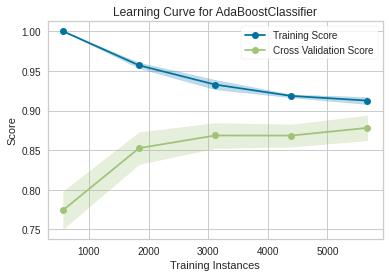

In [15]:
visualizer = LearningCurve(best_full_pipeline, cv=5, train_sizes=np.linspace(.1, 1.0, 5), scoring='f1', n_jobs=-1)

visualizer.fit(features, target)
visualizer.show();

In our case we can see that both training and validation curve are converging, while training curve is decreasing. With this plot we are confident that our model is not overfitting or underfitting.

The gap betwwen our curves and the variability around the cross validated score indicates that our model seems to suffers from error due to variance. But it doesn't seem to suffer from error due to bias low bias since the score is fairly high and there is not much variability around the training score curve.

To improve our model we could increase the number of training observations to help the model to converge.

/home/ubenz/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


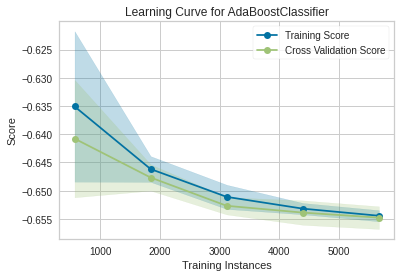

In [16]:
visualizer = LearningCurve(best_full_pipeline, cv=5, train_sizes=np.linspace(.1, 1.0, 5), scoring='neg_log_loss', n_jobs=-1)

visualizer.fit(features, target)
visualizer.show();

**We check what are the most important features for our model**

In [17]:
cat_ft = list(dict(best_full_pipeline["ft_union"].transformer_list)["cat_pipeline"]["onehot"].get_feature_names())
dis_ft = list(dict(best_full_pipeline["ft_union"].transformer_list)["dis_pipeline"]["dis_ct"].get_feature_names())
num_ft = list(dict(best_full_pipeline["ft_union"].transformer_list)["num_pipeline"]["num_ct"].get_feature_names())

full_ft = cat_ft + dis_ft + num_ft

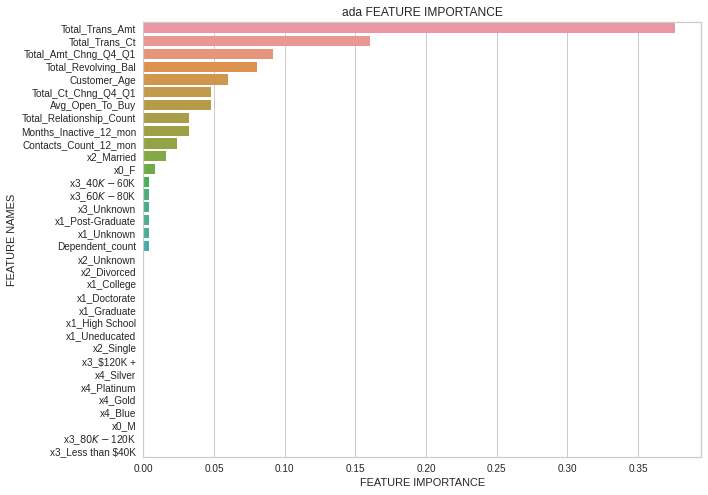

In [18]:
plot_feature_importance(best_model.feature_importances_, full_ft, best_model_name)

Our Categorical features doesn't seem to have strong importance for the model it might be due to the weak predictive power or low support for some of the attributes. It might be interesting to bin some of our categorical variables in order to get less categeory and get more insight.

**We plot the classification report to see the performance of our model ( on train set ) in details**

In [19]:
preds = cross_val_predict(best_full_pipeline, features, target, cv=5)

In [20]:
print(classification_report(target, preds, target_names=["Existing", "Attrited"]))

              precision    recall  f1-score   support

    Existing       0.97      0.98      0.98      5949
    Attrited       0.90      0.86      0.88      1139

    accuracy                           0.96      7088
   macro avg       0.94      0.92      0.93      7088
weighted avg       0.96      0.96      0.96      7088



While our model is facing an imbalanced dataset it still provide good result without overfitting as we saw before, it does a very good job at finding customers that are likely to churn.

* As we can see we have a precision of 0.90. This indicates that when our model predict that an observation is of the positive class (Attrited Customer), it is right 9/10 times.
* Our recall also is fairly high with 0.86. Which indicates that our model succeed to find 86% of the positive observations.
* Overall our model is also getting an accuracy of 0.96, thus our model is not wrongly predicting negative class.

## Let's check how our model perform on unseen data (test data)

In [21]:
# we train our model on the train set
best_full_pipeline.fit(features, target)

Pipeline(steps=[('ft_union',
                 FeatureUnion(transformer_list=[('cat_pipeline',
                                                 Pipeline(steps=[('cat_ct',
                                                                  ColumnTransformer(transformers=[('categoricals',
                                                                                                   'passthrough',
                                                                                                   ['Gender',
                                                                                                    'Education_Level',
                                                                                                    'Marital_Status',
                                                                                                    'Income_Category',
                                                                                                    'Card_Category'])])),
                                                                 ('onehot',
                                                                  OneHotEncoder())])),
                                                ('dis_pipeline',
                                                 Pipeline(steps=[('dis_ct',
                                                                  ColumnTransformer(transformers=...
                                                                  ColumnTransformer(transformers=[('numerics',
                                                                                                   'passthrough',
                                                                                                   ['Customer_Age',
                                                                                                    'Total_Revolving_Bal',
                                                                                                    'Avg_Open_To_Buy',
                                                                                                    'Total_Amt_Chng_Q4_Q1',
                                                                                                    'Total_Trans_Amt',
                                                                                                    'Total_Trans_Ct',
                                                                                                    'Total_Ct_Chng_Q4_Q1'])])),
                                                                 ('variancethreshold',
                                                                  VarianceThreshold()),
                                                                 ('scaler',
                                                                  'passthrough')]))])),
                ('variancethreshold', VarianceThreshold()),
                ['ada',
                 AdaBoostClassifier(learning_rate=0.6, n_estimators=250)]])

In [22]:
# loading test set
path_to_project = '/home/ubenz/Documents/project/bankgraph/test.csv'
X_test, y_test = load_data('data/test.csv',"Attrited Customer", "Existing Customer")
X_test = X_test.drop(["CLIENTNUM"], axis=1)

In [23]:
X_test['Total_Amt_Chng_Q4_Q1'] = power_transform(np.array(X_test['Total_Amt_Chng_Q4_Q1']+1).reshape(-1, 1), method='box-cox')
X_test['Total_Trans_Amt'] = (X_test['Total_Trans_Amt']+1).transform(np.log)

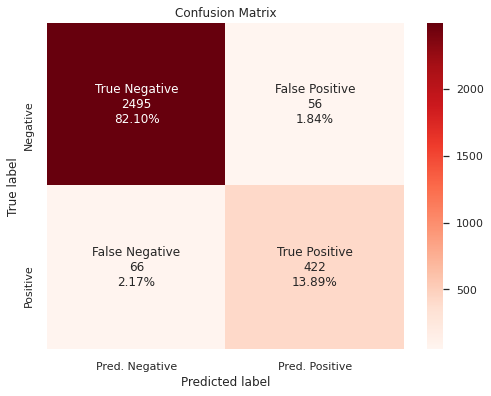

In [24]:
from sklearn.metrics import confusion_matrix
# Using our model to get predictions on unseen data
predicted_probas = best_full_pipeline.predict_proba(X_test)
predicted_class = best_full_pipeline.predict(X_test)

# plotting confusion matrix on test set
plt.figure(figsize=(8,6))
sns.set()
binary_confusion_matrix_plot(y_test,predicted_probas[:, 1])

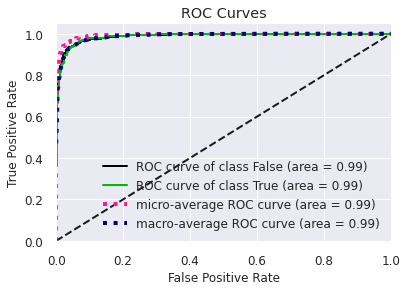

In [25]:
skplt.metrics.plot_roc(y_test, predicted_probas);

/home/ubenz/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


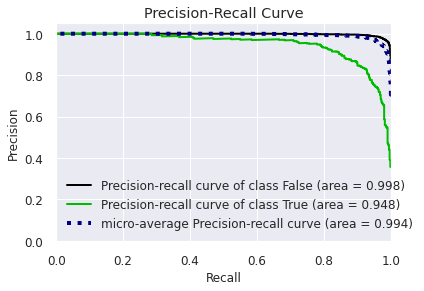

In [26]:
skplt.metrics.plot_precision_recall_curve(y_test, predicted_probas);

In [27]:
print(classification_report(y_test, predicted_class, target_names=["Existing", "Attrited"]))

              precision    recall  f1-score   support

    Existing       0.97      0.98      0.98      2551
    Attrited       0.88      0.86      0.87       488

    accuracy                           0.96      3039
   macro avg       0.93      0.92      0.92      3039
weighted avg       0.96      0.96      0.96      3039



We can observe that our model is robust, and perform as well on train that on unseen data which proves that it will be good to generalize and perform on future customers even though they were not in the database.

* As we can see we have a precision of 0.88. This indicates that when our model predict that an observation is of the positive class (Attrited Customer), it is right more than 8/10 times.
* Our recall also is fairly high with 0.86. Which indicates that our model succeed to find 83% of the positive observations.
* Overall our model is also getting an accuracy of 0.96, thus our model is not wrongly predicting negative class.

**As we mention earlier the goal of this study is not to target all customers, but the top 13% that are the more likely to churn as it is all the budget can allow to target.**

This imply that we don't have to select a cut off, we will only take the highest probas which indicates higher risk that the customers will churn.

In [79]:
# Create a dataframe of probabilities and actual / predicted outcomes
probs_df = pd.DataFrame(np.hstack([predicted_probas, y_test.values.reshape(-1,1), predicted_class.reshape(-1,1)]), columns=['p_no', 'p_yes', 'actual', 'predicted'])

# Sort customers by the probability that they will convert
model_targets = probs_df.sort_values('p_yes', ascending=False)

# Take the top 13%
model_targets = model_targets.head(int(0.13*len(predicted_class)))

# Calculate financial outcomes
model_outcomes = model_targets.actual.apply(lambda x: 
                                            avg_cost if x == 0
                                            else avg_cost + 150)

In [80]:
random_campaign = probs_df.sample(n=int(0.13*len(predicted_class)))

random_outcomes = random_campaign.actual.apply(lambda x: 
                                            avg_cost if x == 0
                                            else avg_cost + avg_revenue)

To compare the efficiency of using this model instead of random guessing we will compare the result of our model to a random campaign.

In [81]:
# Calculate profit
model_profit = sum(model_outcomes)
random_profit = sum(random_outcomes)

print('Number of customers targeted: {:,}/{:,}'.format(len(model_targets), len(X_test)))
print('Accuracy of our Model/Campaign: {:.2f}%'.format(model_targets.actual.sum() / len(model_outcomes)*100.))
print()
print('Expected profit of model policy: €{:,}'.format(model_profit))
print('Expected profit of random policy: €{:,}'.format(random_profit))
print()
print('Lift over random: x{:.2f} or €{:,}'.format(model_profit / random_profit, model_profit - random_profit))


Number of customers targeted: 395/3,039
Accuracy of our Model/Campaign: 95.19%

Expected profit of model policy: €48,895
Expected profit of random policy: €1,795

Lift over random: x27.24 or €47,100


**If we had to pick randomly customers to target we would expect a profit of 1,795€ while using the model to determine which customers to target we would expect a profit of 48,895€. Which represent a lift of almost 27.**

Therefore we highly suggest to use this model to select the customers.

We can now ask the bank manager if he is satisfied with the result.

We could charge him to try to enhance the model by implementing new features (implementing association of features, binning features to reduce dimensionality of categorical features) or by adding more observations to the training set.